# ROOT LOCUS ANALYSIS

# Preliminaries

In [1]:
#!pip install -q control

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import control
from typing import List, Tuple, Optional

# Helpers

## plotStep

In [3]:
def plotStep(tf, title:str="", is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    times, yv = control.step_response(tf)
    plt.plot(times, yv)
    plt.title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([1], [1, 1])
plotStep(tf, is_plot=False)
print("OK!")

OK!


## complex_magnitude

In [4]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

## plotRootLocusWithGains

In [17]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float], xlim:Optional[np.ndarray]=None, title:str="", 
      ylim:Optional[np.ndarray]=None, 
      markersize_multiplier:float=100, is_plot:bool=True):
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
    """
    ax = plt.axes()
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim, 
          ylim=ylim, ax=ax)
    ax.set_title(title)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(str(gain), (xv[i], yv[i]), color='blue')
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    #
    if not is_plot:
        plt.close()

# Tests
tf = control.zpk([], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.1, 0.2, 0.25, 1], markersize_multiplier=100, ylim=[-3, 3], is_plot=False)
print("OK!")

OK!


# Root Locus Analysis

## Motivation

In [6]:
# An alternative way to construct a transfer function by specifying: 
#    zeros, poles, multiplier times the transfer function
ol_tf = control.zpk([], [-2], [5])
ol_tf

TransferFunction(array([5.]), array([1., 2.]))

Let $G(s)$ be the open loop transfer function and $H(s)$ be the closed loop transfer function for p-control.
That is, $C(s) = k_P$. Consider the first order system $G(s) = \frac{k}{s - p}$.
\begin{eqnarray}
H(s) & = & \frac{C(s) G(s)}{1 + C(s) G(s)} \\
 & = & \frac{k_P k}{s - p + k_P k} \\
\end{eqnarray}

In [9]:
# Now create the closed loop transfer function for p-control with a gain of kP
kP = 2
cl_tf = control.feedback(kP*ol_tf) # Calculates H(s)
cl_tf

TransferFunction(array([10.]), array([ 1., 12.]))

We can compare open loop with closed loop settling times and dcgain by plotting their step response.

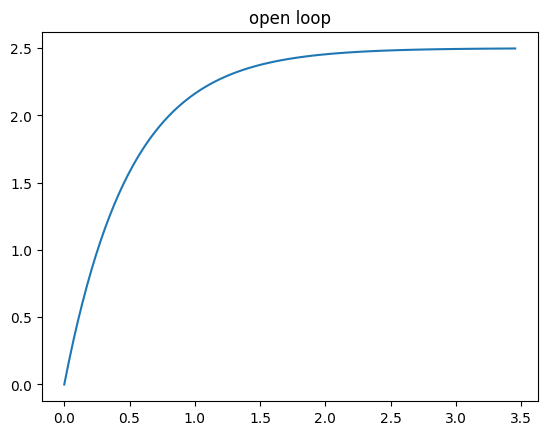

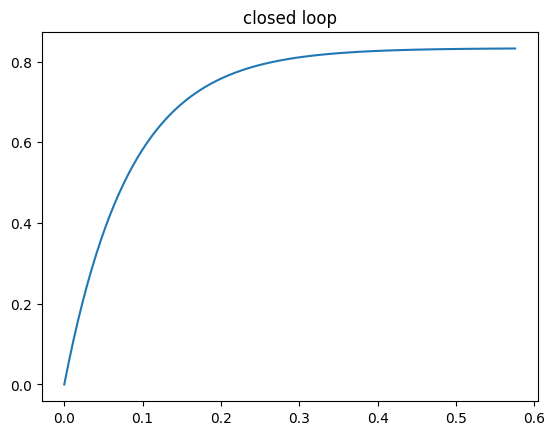

In [10]:
plotStep(ol_tf, title="open loop")
plt.figure()
plotStep(cl_tf, title="closed loop")

This is cumbersome and time consuming if we want to compare many designs. Also, it gives no insight into the effect of $k_P$.

**We want a more direct way to see the closed poles as $k_P$ is changed.**

## Root locus plots

The root locus plot displays the poles of the *closed loop* transfer function for the open loop under p-control.

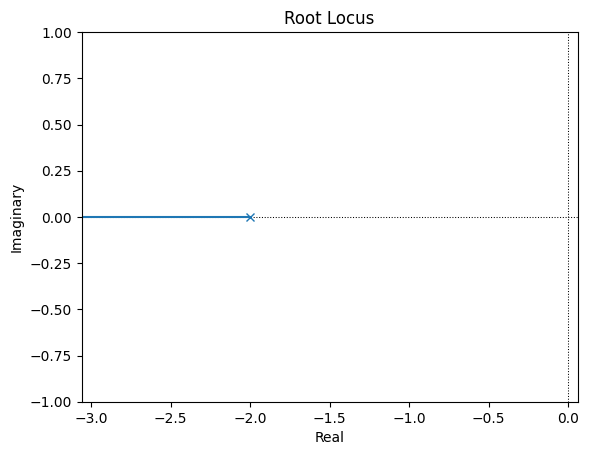

In [12]:
ol_tf = control.zpk([], [-2], [5])
_ = control.root_locus(ol_tf, grid=False)

Open loop poles are indicated by an "X"; open loop zeros are indicated by "O". The plot can be annotated with values of $k_P$ associated with specific poles.

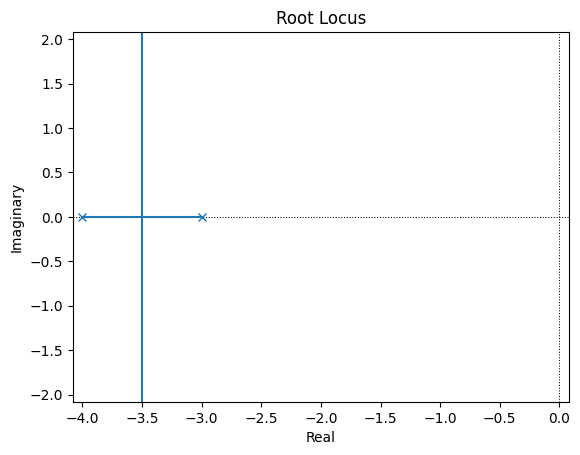

In [32]:
ol_tf = control.zpk([], [-3, -4], [5])
_ = control.root_locus(ol_tf, grid=False)

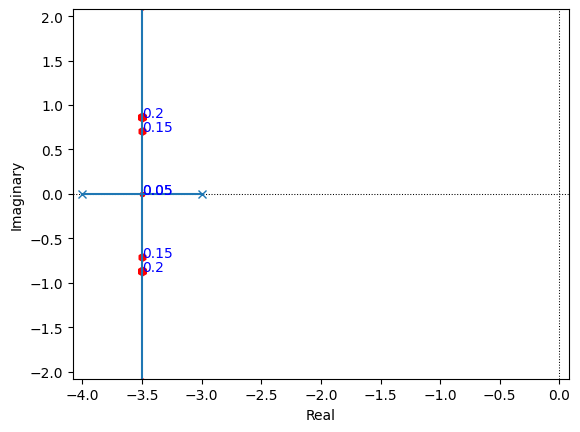

In [33]:
# Annotate the plot with the values of different gains
ol_tf = control.zpk([], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[0.05, 0.15, 0.2, 1], markersize_multiplier=200 )

**Questions**
1. How do closed loop poles move relative to open loop poles?
2. What is the value of $k_P$ (gain) the gives us the fastest settling time without oscillations?

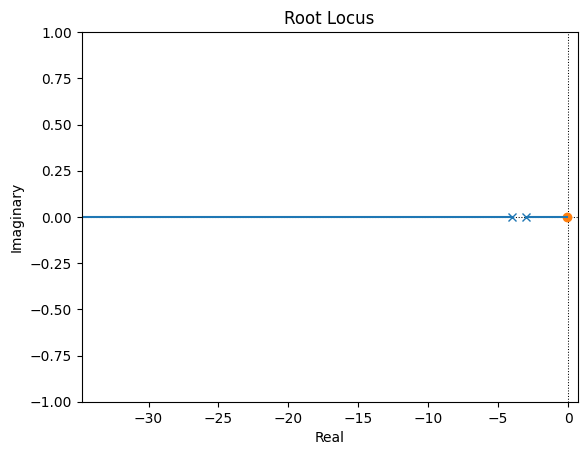

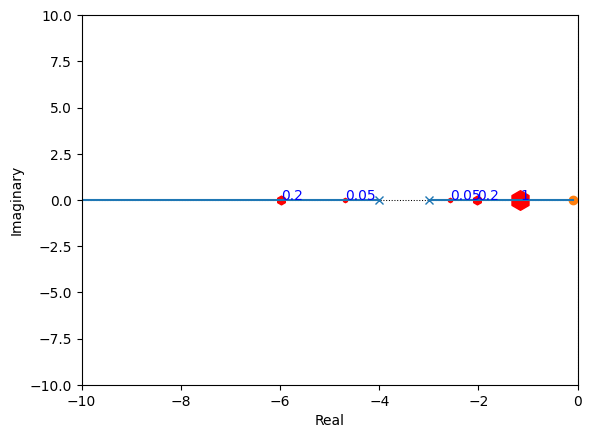

In [35]:
# Effect of an open loop zeron
ol_tf = control.zpk([-0.1], [-3, -4], [5])
_ = control.root_locus(ol_tf, grid=False)
plt.figure()
plotRootLocusWithGains(ol_tf, gains=[0.05, 0.2, 1], markersize_multiplier=200, ylim=[-10, 10], xlim=[-10, 0] )

**Questions**
1. What is the trajectory of the poles as $k_P$ increases?
1. Why did the addition of a 0 eliminate oscillations?

# Rules for Constructing Root Locus Plots

# Designing P Control With Root Locus